In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image
import os

#==========================================================================
# JUPYTER PATH STUFF. Not present in the main script coz does not affect it
# =========================================================================

os.chdir("..")


root = Path().resolve()
while root != root.parent:
    if (root / "scripts").is_dir():
        sys.path.insert(0, str(root))
        print("Added to sys.path:", root)
        break
    root = root.parent
else:
    raise RuntimeError("Could not find 'scripts' directory above this notebook")

from scripts.src import (
    build_model_and_tokenizer,
    get_image_transform,
    get_label_text_embeddings,
)

Added to sys.path: /home/woody/iwi5/iwi5362h/ALBEF


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def infer_png_path(images_root, image_id):
    png_path = images_root / f"{image_id}.png"
    if png_path.exists():
        return png_path
    raise FileNotFoundError(f"No PNG found for image_id={image_id} at {png_path}")


def get_patch_embeddings(
    model,
    img_tensor,
    device,
    patch_grid= 16,
):
    """
    img_tensor: (1, 3, H, W) on device
    Returns:
        patch_feats: (H', W', D) where H'=W'=patch_grid
    """
    img_tensor = img_tensor.to(device, non_blocking=True)

    with torch.no_grad():
        image_embeds = model.visual_encoder(img_tensor)  # (1, N+1, 768)
        image_embeds = model.vision_proj(image_embeds)   # (1, N+1, D)
        patch_tokens = image_embeds[:, 1:, :]            # (1, N, D)
        patch_tokens = F.normalize(patch_tokens, dim=-1)

    _, N, D = patch_tokens.shape
    expected_N = patch_grid * patch_grid
    if N != expected_N:
        raise ValueError(
            f"Expected {expected_N} patches for grid {patch_grid}x{patch_grid}, got {N}."
        )

    patch_tokens = patch_tokens.view(1, patch_grid, patch_grid, D)
    return patch_tokens.squeeze(0)  # (H', W', D)


def compute_heatmap(
    patch_feats,   # (H', W', D)
    text_feat,     # (D,)
    upsample_size,
):
    """
    Compute patch–text similarity and upsample to upsample_size x upsample_size.
    Returns heatmap as np.ndarray (H, W) in [0, 1].
    """
    H, W, D = patch_feats.shape
    text_feat = text_feat.view(1, 1, D)  # (1, 1, D)

    # similarity per patch: (H, W)
    sim = (patch_feats * text_feat).sum(dim=-1)
    sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-6)

    sim_4d = sim.unsqueeze(0).unsqueeze(0)  # (1, 1, H', W')
    sim_up = F.interpolate(
        sim_4d,
        size=(upsample_size, upsample_size),
        mode="bilinear",
        align_corners=False,
    )
    sim_up = sim_up.squeeze(0).squeeze(0)   # (H_up, W_up)

    return sim_up.cpu().numpy().astype(np.float32)

In [4]:
images_root = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/test")
output_dir = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps")
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
config_path = "configs/Pretrain.yaml"
ckpt_path = "output_mimic_a40_transformations/checkpoint_29.pth"
device = "cuda"

In [6]:
# Load model/tokenizer/config once and reuse
model, tokenizer, config, device = build_model_and_tokenizer(
    config_path=config_path,
    ckpt_path=ckpt_path,
    device=device,
)

image_res = config["image_res"]

[Model] Building ALBEF...
[Model] State dict loaded: <All keys matched successfully>


In [7]:
transform = get_image_transform(image_res)

In [8]:
# Load label CSV to get image_ids + label names
df = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/image_labels_test.csv")
id_col = df.columns[0]
label_cols = list(df.columns[1:])
print(f"[Data] Found {len(df)} rows, {len(label_cols)} labels")

[Data] Found 3000 rows, 28 labels


In [9]:
# For debugging a small batch
df = df.iloc[: 100].reset_index(drop=True)
print(f"[Data] Limiting to {len(df)} images (max_images=100)")

[Data] Limiting to 100 images (max_images=100)


In [10]:
df["__has_png__"] = df[id_col].apply(
    lambda x: (images_root / f"{x}.png").exists()
)
df = df[df["__has_png__"]].reset_index(drop=True)
print(f"[Data] After PNG filter: {len(df)} images")

image_ids = df[id_col].tolist()
label_names = label_cols

[Data] After PNG filter: 100 images


In [11]:
# Multi-prompt text embeddings
label_embs = get_label_text_embeddings(
    model=model,
    tokenizer=tokenizer,
    labels=label_names,
    device=device,
    max_length=32,
)  # (L, D)
label_embs = label_embs.to(device)
print("[Text] Label embeddings shape:", label_embs.shape)

[Text] Total prompts: 136 for 28 labels
[Text] Label embeddings shape: torch.Size([28, 256])


In [12]:
heatmap_index_records = []

for idx, image_id in enumerate(image_ids, start=1):
    try:
        img_path = infer_png_path(images_root, image_id)
    except FileNotFoundError as e:
        print("[WARN]", e)
        continue

    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # (1, 3, H, W)

    try:
        patch_feats = get_patch_embeddings(
            model=model,
            img_tensor=img_tensor,
            device=device,
            patch_grid=16,  # 256 / 16 = 16;
        )
    except Exception as e:
        print(f"[ERROR] Patch features failed for {image_id}: {e}")
        continue

    heatmaps = {}
    for j, label in enumerate(label_names):
        text_feat = label_embs[j]  # (D,)
        hmap = compute_heatmap(
            patch_feats=patch_feats,
            text_feat=text_feat,
            upsample_size=image_res,
        )
        heatmaps[label] = torch.from_numpy(hmap)  # (H, W) tensor

    out_path = output_dir / f"{image_id}.pt"
    torch.save(heatmaps, out_path)
    heatmap_index_records.append(
        {"image_id": image_id, "heatmap_path": str(out_path)}
    )

    if idx % 50 == 0 or idx == len(image_ids):
        print(f"[Heatmaps] Processed {idx}/{len(image_ids)} images")

[Heatmaps] Processed 50/100 images
[Heatmaps] Processed 100/100 images


In [13]:
print("Number of patches:", patch_feats.shape)

Number of patches: torch.Size([16, 16, 256])


In [14]:
index_df = pd.DataFrame(heatmap_index_records)
index_df.head()

,image_id,heatmap_path
0,e0dc2e79105ad93532484e956ef8a71a,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
1,0aed23e64ebdea798486056b4f174424,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
2,aa15cfcfca7605465ca0513902738b95,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
3,665c4a6d2693dc0286d65ab479c9b169,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...
4,42da2c134b53cb5594774d3d29faac59,/home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...


In [15]:
index_df["image_id"][0]

'e0dc2e79105ad93532484e956ef8a71a'

In [16]:
index_df["heatmap_path"][0]

'/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps/e0dc2e79105ad93532484e956ef8a71a.pt'

In [17]:
img = Image.open(images_root / f"""{index_df["image_id"][0]}.png""").convert("RGB")

In [18]:
heatmap = torch.load(index_df["heatmap_path"][0], map_location="cpu")

In [19]:
len(heatmaps.keys())

28

In [20]:
hm = heatmaps["ILD"].float()  # (H, W) tensor
# ensure it's in [0,1]; recompute if needed
hm_min, hm_max = hm.min(), hm.max()
hm = (hm - hm_min) / (hm_max - hm_min + 1e-6)
hm = hm.numpy()

In [21]:
def overlay_heatmap_on_image(
    img: Image.Image,
    heatmap: np.ndarray,
    alpha: float = 0.4,
    cmap: str = "jet",
    show: bool = True,
    save_path: str = None,
    title: str = None,
):
    """
    img: PIL Image (RGB)
    heatmap: np.ndarray (H, W) in [0,1]
    """
    # Resize heatmap to image size if needed
    H_img, W_img = img.size[1], img.size[0]
    if heatmap.shape != (H_img, W_img):
        from PIL import Image as PILImage
        hm_img = PILImage.fromarray((heatmap * 255).astype(np.uint8))
        hm_img = hm_img.resize((W_img, H_img), resample=PILImage.BILINEAR)
        heatmap = np.array(hm_img) / 255.0

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, interpolation="nearest")
    ax.imshow(
        heatmap,
        cmap=cmap,
        alpha=alpha,
        interpolation="nearest",
    )
    ax.axis("off")
    if title is not None:
        ax.set_title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
        print(f"[Output] Saved overlay to {save_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

In [22]:
def load_meta(meta_csv):
    """
    Load VinDr meta CSV with columns: image_id, dim0, dim1
    Returns dict: image_id -> (orig_height, orig_width)
    """
    df = pd.read_csv(meta_csv)
    meta = {}
    for _, r in df.iterrows():
        image_id = r["image_id"]
        # dim0 = height, dim1 = width (typical numpy convention)
        orig_h = int(r["dim0"])
        orig_w = int(r["dim1"])
        meta[image_id] = (orig_h, orig_w)
    return meta


def visualize_vindr_boxes(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    save_path: str = None,
):
    """
    Visualize a 256x256 VinDr PNG with its bounding boxes,
    scaling the original annotations using train_meta.csv.
    """
    # Load annotations
    df = pd.read_csv(annotations_csv)
    rows = df[df["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id} in {annotations_csv}")

    # Load meta for original size
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"image_id={image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # Load 256x256 PNG
    img_path = Path(images_root) / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"PNG not found: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size

    assert w_png == h_png == 256, f"Expected 256x256 PNG, got {w_png}x{h_png}"

    # Scaling factors from original -> 256x256
    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img, cmap="gray")
    ax.axis("off")

    for _, r in rows.iterrows():
        if r.get("class_name") != "ILD":
            continue
        x_min_orig = r["x_min"]
        y_min_orig = r["y_min"]
        x_max_orig = r["x_max"]
        y_max_orig = r["y_max"]
        label = r.get("class_name", "")

        # Scale to PNG coordinates
        x_min = x_min_orig * scale_x
        y_min = y_min_orig * scale_y
        x_max = x_max_orig * scale_x
        y_max = y_max_orig * scale_y

        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)
        if label:
            ax.text(
                x_min,
                max(y_min - 2, 0),
                label,
                fontsize=8,
                color="yellow",
                bbox=dict(facecolor="black", alpha=0.5, edgecolor="none"),
            )

    plt.tight_layout()
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=150)
        print(f"Saved visualization to {save_path}")
    else:
        plt.show()

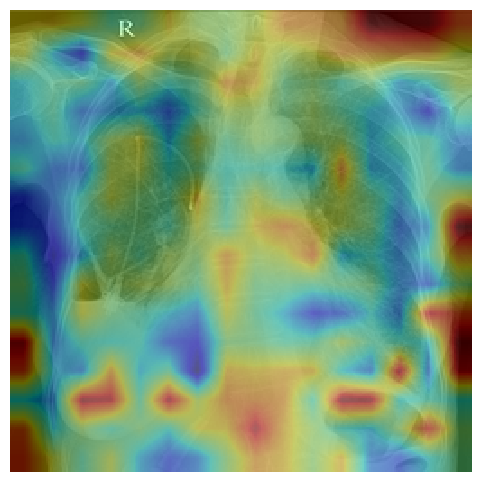

In [57]:
# Pleural effusion

overlay_heatmap_on_image(img, hm)

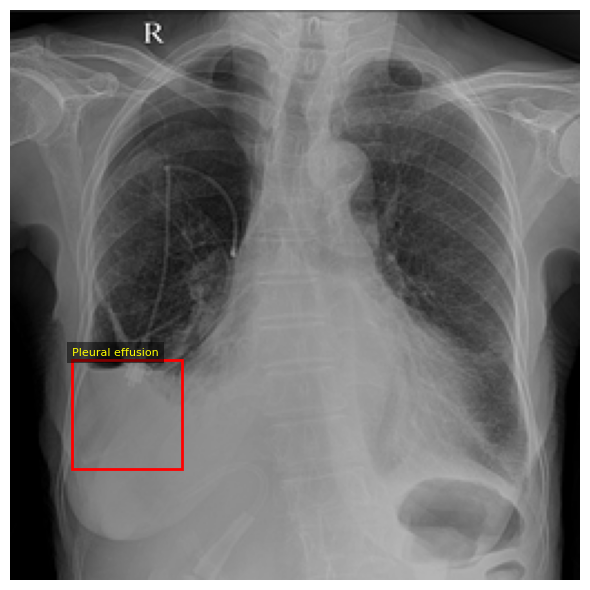

In [59]:
visualize_vindr_boxes(
    index_df["image_id"][0],
    images_root,
    "/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv",
    "/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv",
)

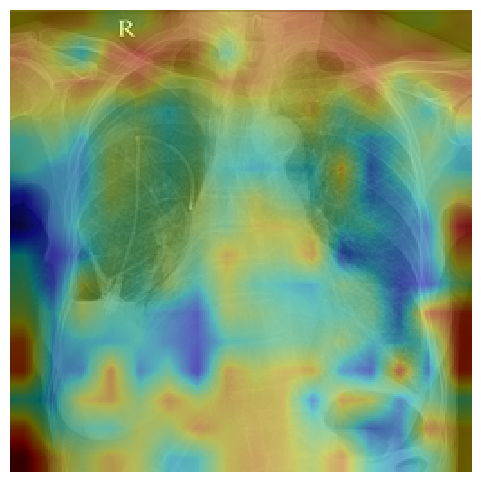

In [66]:
# Cardiomegaly	

overlay_heatmap_on_image(img, hm)

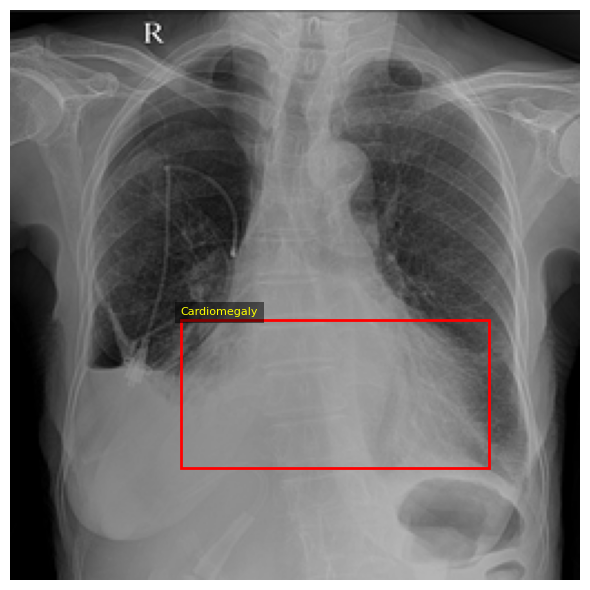

In [67]:
visualize_vindr_boxes(
    index_df["image_id"][0],
    images_root,
    "/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv",
    "/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv",
)

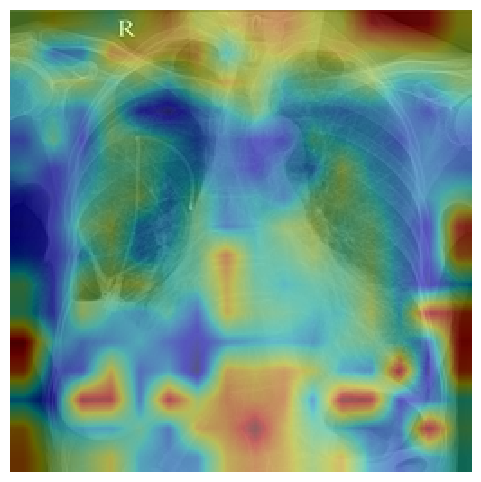

In [23]:
# ILD	

overlay_heatmap_on_image(img, hm)

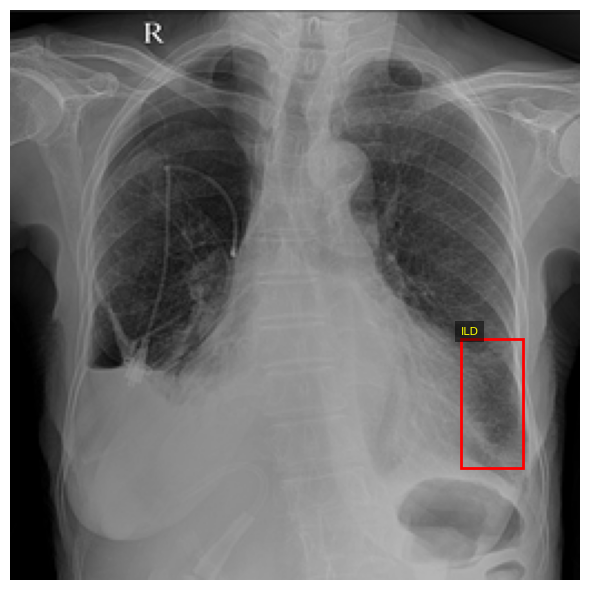

In [24]:
visualize_vindr_boxes(
    index_df["image_id"][0],
    images_root,
    "/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv",
    "/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv",
)

In [25]:
annot_test = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv")

In [26]:
annot_test[annot_test.image_id == index_df["image_id"][0]]

,image_id,class_name,x_min,y_min,x_max,y_max
0,e0dc2e79105ad93532484e956ef8a71a,Calcification,1221.560976,661.580417,1343.298780,783.318222
1,e0dc2e79105ad93532484e956ef8a71a,Cardiomegaly,638.695122,1310.848710,1800.737805,1937.982856
2,e0dc2e79105ad93532484e956ef8a71a,ILD,1693.756098,1392.007246,1929.853659,1941.671881
3,e0dc2e79105ad93532484e956ef8a71a,Pneumothorax,399.924053,145.803282,1016.600328,510.138208
4,e0dc2e79105ad93532484e956ef8a71a,Pneumothorax,334.300846,493.762382,453.145487,744.509170
5,e0dc2e79105ad93532484e956ef8a71a,Pleural effusion,229.975703,1482.203045,644.450374,1945.701602
6,e0dc2e79105ad93532484e956ef8a71a,Atelectasis,379.275719,1248.225409,504.063792,1500.029913
7,e0dc2e79105ad93532484e956ef8a71a,Pneumothorax,283.456305,1381.926915,414.929454,1546.825440


In [27]:
def cosine_sim_matrix(embs):
    """
    embs: (L, D) normalized
    returns: (L, L) cosine similarity matrix
    """
    with torch.no_grad():
        sims = embs @ embs.t()   # (L, L)
    return sims.cpu().numpy()

In [28]:
DEBUG_IMAGE_ID = ['e0dc2e79105ad93532484e956ef8a71a']
DEBUG_LABELS = ["Pleural effusion", "Cardiomegaly", "ILD"]

In [29]:
label_to_idx = {lb: i for i, lb in enumerate(label_cols)}
idxs = [label_to_idx[lb] for lb in DEBUG_LABELS]
debug_embs = label_embs[idxs]  # (L_debug, D)

In [30]:
debug_embs.shape

torch.Size([3, 256])

In [31]:
sim_mat = cosine_sim_matrix(debug_embs)
print("\n[DEBUG] Cosine similarity between DEBUG_LABELS:")
print("Labels:", DEBUG_LABELS)
print(np.round(sim_mat, 3))


[DEBUG] Cosine similarity between DEBUG_LABELS:
Labels: ['Pleural effusion', 'Cardiomegaly', 'ILD']
[[0.964 0.641 0.61 ]
 [0.641 0.928 0.564]
 [0.61  0.564 0.886]]


In [32]:
img_tensor = transform(img).unsqueeze(0)

In [33]:
patch_feats = get_patch_embeddings(model, img_tensor, device, patch_grid=16)
print("[DEBUG] patch_feats shape:", patch_feats.shape)

[DEBUG] patch_feats shape: torch.Size([16, 16, 256])


In [34]:
heatmaps = {}
for lb, idx_lb in zip(DEBUG_LABELS, idxs):
    text_feat = debug_embs[DEBUG_LABELS.index(lb)]  # (D,)
    heatmap = compute_heatmap(
        patch_feats=patch_feats,
        text_feat=text_feat,
        upsample_size=image_res,
    )
    heatmaps[lb] = heatmap

In [35]:
 # ----- pairwise correlation between heatmaps -----
print("\n[DEBUG] Pearson correlation between heatmaps:")
Ld = len(DEBUG_LABELS)
corr_mat = np.zeros((Ld, Ld), dtype=np.float32)
for i in range(Ld):
    for j in range(Ld):
        h1 = heatmaps[DEBUG_LABELS[i]].ravel()
        h2 = heatmaps[DEBUG_LABELS[j]].ravel()
        corr = np.corrcoef(h1, h2)[0, 1]
        corr_mat[i, j] = corr
print("Labels:", DEBUG_LABELS)
print(np.round(corr_mat, 3))


[DEBUG] Pearson correlation between heatmaps:
Labels: ['Pleural effusion', 'Cardiomegaly', 'ILD']
[[1.    0.555 0.668]
 [0.555 1.    0.234]
 [0.668 0.234 1.   ]]


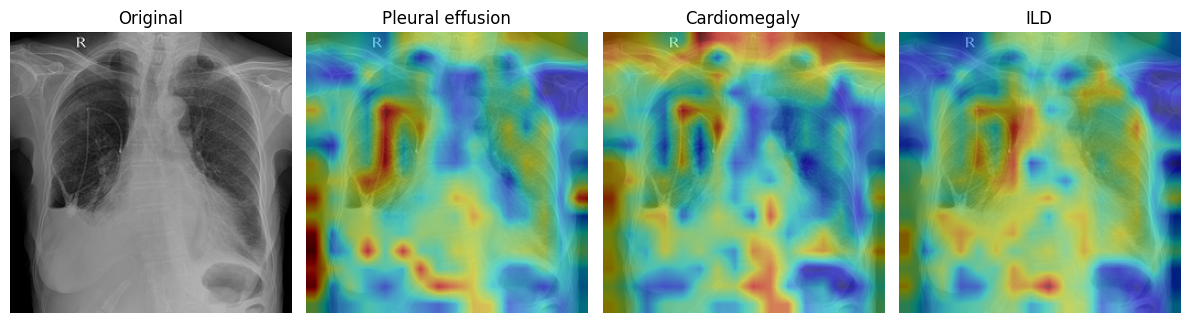

In [36]:
# ----- visualize in a grid -----
fig, axes = plt.subplots(1, len(DEBUG_LABELS) + 1, figsize=(3*(len(DEBUG_LABELS)+1), 4))

# original image
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

for k, lb in enumerate(DEBUG_LABELS, start=1):
    axes[k].imshow(img, cmap="gray")
    axes[k].imshow(heatmaps[lb], alpha=0.5, cmap="jet")
    axes[k].set_title(lb)
    axes[k].axis("off")

plt.tight_layout()
plt.show()

In [37]:
def compute_heatmap_conservative(patch_feats, text_feat, upsample_size):
    """
    patch_feats: (H', W', D) normalized
    text_feat:   (D,) normalized
    """
    # raw cosine similarity
    sim = (patch_feats * text_feat).sum(dim=-1)  # (H', W')

    # center and keep only positive evidence
    sim = sim - sim.mean()
    sim = torch.clamp(sim, min=0.0)

    # if everything is <= 0 after mean subtraction, just return zeros
    if sim.max() < 1e-6:
        sim = torch.zeros_like(sim)
    else:
        sim = sim / (sim.max() + 1e-6)  # now in [0,1], but only for "above-average" patches

    sim_4d = sim.unsqueeze(0).unsqueeze(0)
    sim_up = F.interpolate(
        sim_4d,
        size=(upsample_size, upsample_size),
        mode="bilinear",
        align_corners=False,
    )
    sim_up = sim_up.squeeze(0).squeeze(0)
    return sim_up.cpu().numpy().astype(np.float32)

In [38]:
heatmaps_conservative = {}
for lb, idx_lb in zip(DEBUG_LABELS, idxs):
    text_feat = debug_embs[DEBUG_LABELS.index(lb)]  # (D,)
    heatmap = compute_heatmap_conservative(
        patch_feats=patch_feats,
        text_feat=text_feat,
        upsample_size=image_res,
    )
    heatmaps_conservative[lb] = heatmap

In [39]:
 # ----- pairwise correlation between heatmaps -----
print("\n[DEBUG] Pearson correlation between heatmaps:")
Ld = len(DEBUG_LABELS)
corr_mat = np.zeros((Ld, Ld), dtype=np.float32)
for i in range(Ld):
    for j in range(Ld):
        h1 = heatmaps_conservative[DEBUG_LABELS[i]].ravel()
        h2 = heatmaps_conservative[DEBUG_LABELS[j]].ravel()
        corr = np.corrcoef(h1, h2)[0, 1]
        corr_mat[i, j] = corr
print("Labels:", DEBUG_LABELS)
print(np.round(corr_mat, 3))


[DEBUG] Pearson correlation between heatmaps:
Labels: ['Pleural effusion', 'Cardiomegaly', 'ILD']
[[1.    0.503 0.502]
 [0.503 1.    0.138]
 [0.502 0.138 1.   ]]


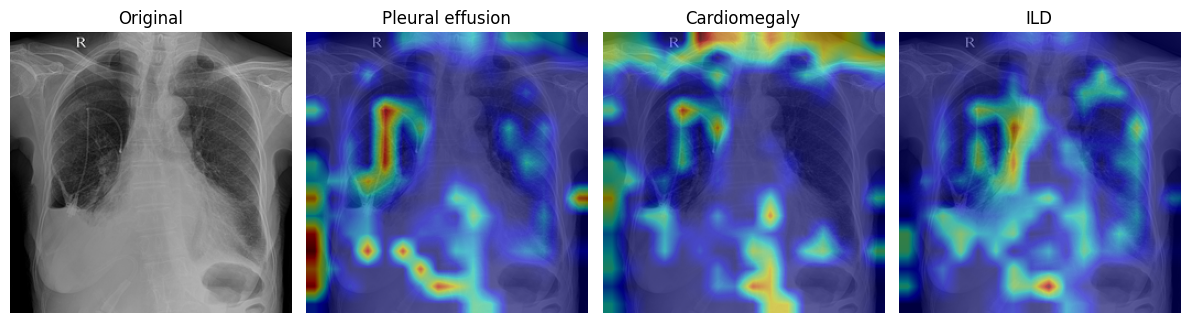

In [40]:
# ----- visualize in a grid -----
fig, axes = plt.subplots(1, len(DEBUG_LABELS) + 1, figsize=(3*(len(DEBUG_LABELS)+1), 4))

# original image
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

for k, lb in enumerate(DEBUG_LABELS, start=1):
    axes[k].imshow(img, cmap="gray")
    axes[k].imshow(heatmaps_conservative[lb], alpha=0.5, cmap="jet")
    axes[k].set_title(lb)
    axes[k].axis("off")

plt.tight_layout()
plt.show()